# Redes Neuronales Artificiales - Trabajo Práctico 1

### Guillermina Cabrol, Magalí Giansiracusa, Sofía Goldberg



## Introducción

En este trabajo implementaremos modelos de redes neuronales artificiales para aprendizaje supervisado, para dos problemas distintos: **Diagnóstico de cáncer de mamas** y **Eficiencia energética**. Se hará un análisis de los datos obtenidos y los modelos construidos.

Las principales librerías que serán utilizadas para el desarrollo de los modelos son `Numpy` y `Matplotlib`. También usaremos `requests` para cargar los datos y `random` para generar seeds necesarias para que los resultados sean reproducibles.

In [19]:
import numpy as np 
from matplotlib import pyplot as plt, cm
import requests
import random

Creamos una función para separar los datos en entrenamiento (`train`), validación (`val`) y testeo (`test`). Como sus nombres indican, usaremos los datos de entrenamiento para entrenar la red, los de validación para comprobar qué tan bien predice la red para datos no utilizados en el entrenamiento y poder ajustar parámetros para mejorar la performance, y por último, usaremos el dataset de testeo para calificar el modelo final y estimar su desempeño en la realidad.

In [20]:
from math import ceil, floor

def split(
        X: np.ndarray,
        Z: np.ndarray,
        train_size: float,
        val_size: float,
        test_size: float,
    ) -> tuple:

    """Separa el conjunto de datos en conjuntos de train, validation y test al azar.

    Parameters
    ----------
    X: datos de entrada.
    
    Z: datos objetivo.
    
    train_size: proporción del dataset a incluir en train.

    val_size: proporción del dataset a incluir en validation.

    test_size: proporción del dataset a incluir en test.

    random_state: sirve para que los resultados sean reproducibles.

    Returns
    -------
    split: lista que contiene el conjunto de test y el de train.
    """

    n = len(X)

    n_test = ceil(test_size * n)
    n_train = floor(train_size * n)
    n_val = ceil(val_size * n)

    n_train, n_test, n_val = int(n_train), int(n_test), int(n_val)


    X_train = X[:n_train]
    X_val = X[n_train:n_train + n_test]
    X_test = X[n_train + n_test:]

    Z_train = Z[:n_train]
    Z_val = Z[n_train:n_train + n_test]
    Z_test = Z[n_train + n_test:]

    return X_train, Z_train, X_val, Z_val, X_test, Z_test

## Diagnóstico de cáncer de mamas

Tenemos un conjunto de datos con los resultados para distintos pacientes de un examen para determinar si tienen cáncer de mamas maligno o benigno. Cada columna representa una característica obtenida en el examen realizado, y el objetivo será determinar si es posible predecir el diagnóstico final utilizando una red neuronal.

Primero, cargamos los datos, y los separamos en X (datos de entrada) y Z (datos objetivo).

In [174]:
r = requests.get('https://git.exactas.uba.ar/redes-neuronales/clases/-/raw/master/practicas/datos/tp1_ej1_training.csv')
data = np.loadtxt(r.iter_lines(), delimiter=',')

data = np.random.RandomState(seed=42).permutation(data)

X = data[:,1:]

Z = data[:,0:1]

Dividimos los datos:

- 80% para entrenamiento.
- 15% para validación.
- 5% para testeo.

In [175]:
X_train, Z_train, X_val, Z_val, X_test, Z_test = split(X, Z, 0.8, 0.15, 0.05)

### Análisis de datos

Vamos a realizar un análisis de los datos de entrenamiento para ver su distribución y cuán correlacionados están, para así decidir si es necesario realizar alguna modificación.

Para esto, pasaremos los datos a formato *DataFrame* usando la librería `Pandas`.

In [176]:
import pandas as pd

df = pd.DataFrame(X_train, columns=['Radio', 'Textura', 'Perímetro', 'Área', 'Suavidad', 'Compacidad', 'Concavidad', 'Puntos cóncavos', 'Simetría', 'Dimensión fractal'])
df

Radio  Textura  Perímetro      Área  Suavidad  Compacidad  Concavidad  \
0    20.284   13.181    158.656  1179.240     1.205       1.878       4.898   
1    18.298   11.596    154.492  1370.281     0.933       1.291       5.229   
2    23.810   26.490     48.872   740.533     1.970       2.042       0.427   
3    25.137   15.136     94.484   694.296     1.594       0.683       1.846   
4    25.586   12.223    147.360  1598.108     0.816       1.121       3.131   
..      ...      ...        ...       ...       ...         ...         ...   
323  25.037   18.467     78.939   371.967     1.770       1.504       1.338   
324  20.723   26.535     90.812   742.614     1.972       1.682       2.265   
325  18.179   13.237    152.105  1134.127     1.239       1.893       5.015   
326  17.415   22.883     83.133   366.730     1.783       2.640       2.928   
327  16.014   28.302     85.181   969.770     2.177       1.208       3.646   

     Puntos cóncavos  Simetría  Dimensión fractal  
0              5.932     1.029              2.019  
1              6.866     0.760              2.164  
2              0.434     0.651              0.267  
3              2.414     0.784              0.830  
4              2.793     0.814              1.933  
..               ...       ...                ...  
323            1.802     0.768              0.579  
324            2.119     0.843              1.098  
325            6.325     0.572              2.340  
326            4.197     0.394              1.249  
327            5.480     1.217              0.593  

[328 rows x 10 columns]

Realizamos un gráfico usando la librería `seaborn` para visualizar mejor cómo se relacionan los datos y cuáles son los valores de los mismos.

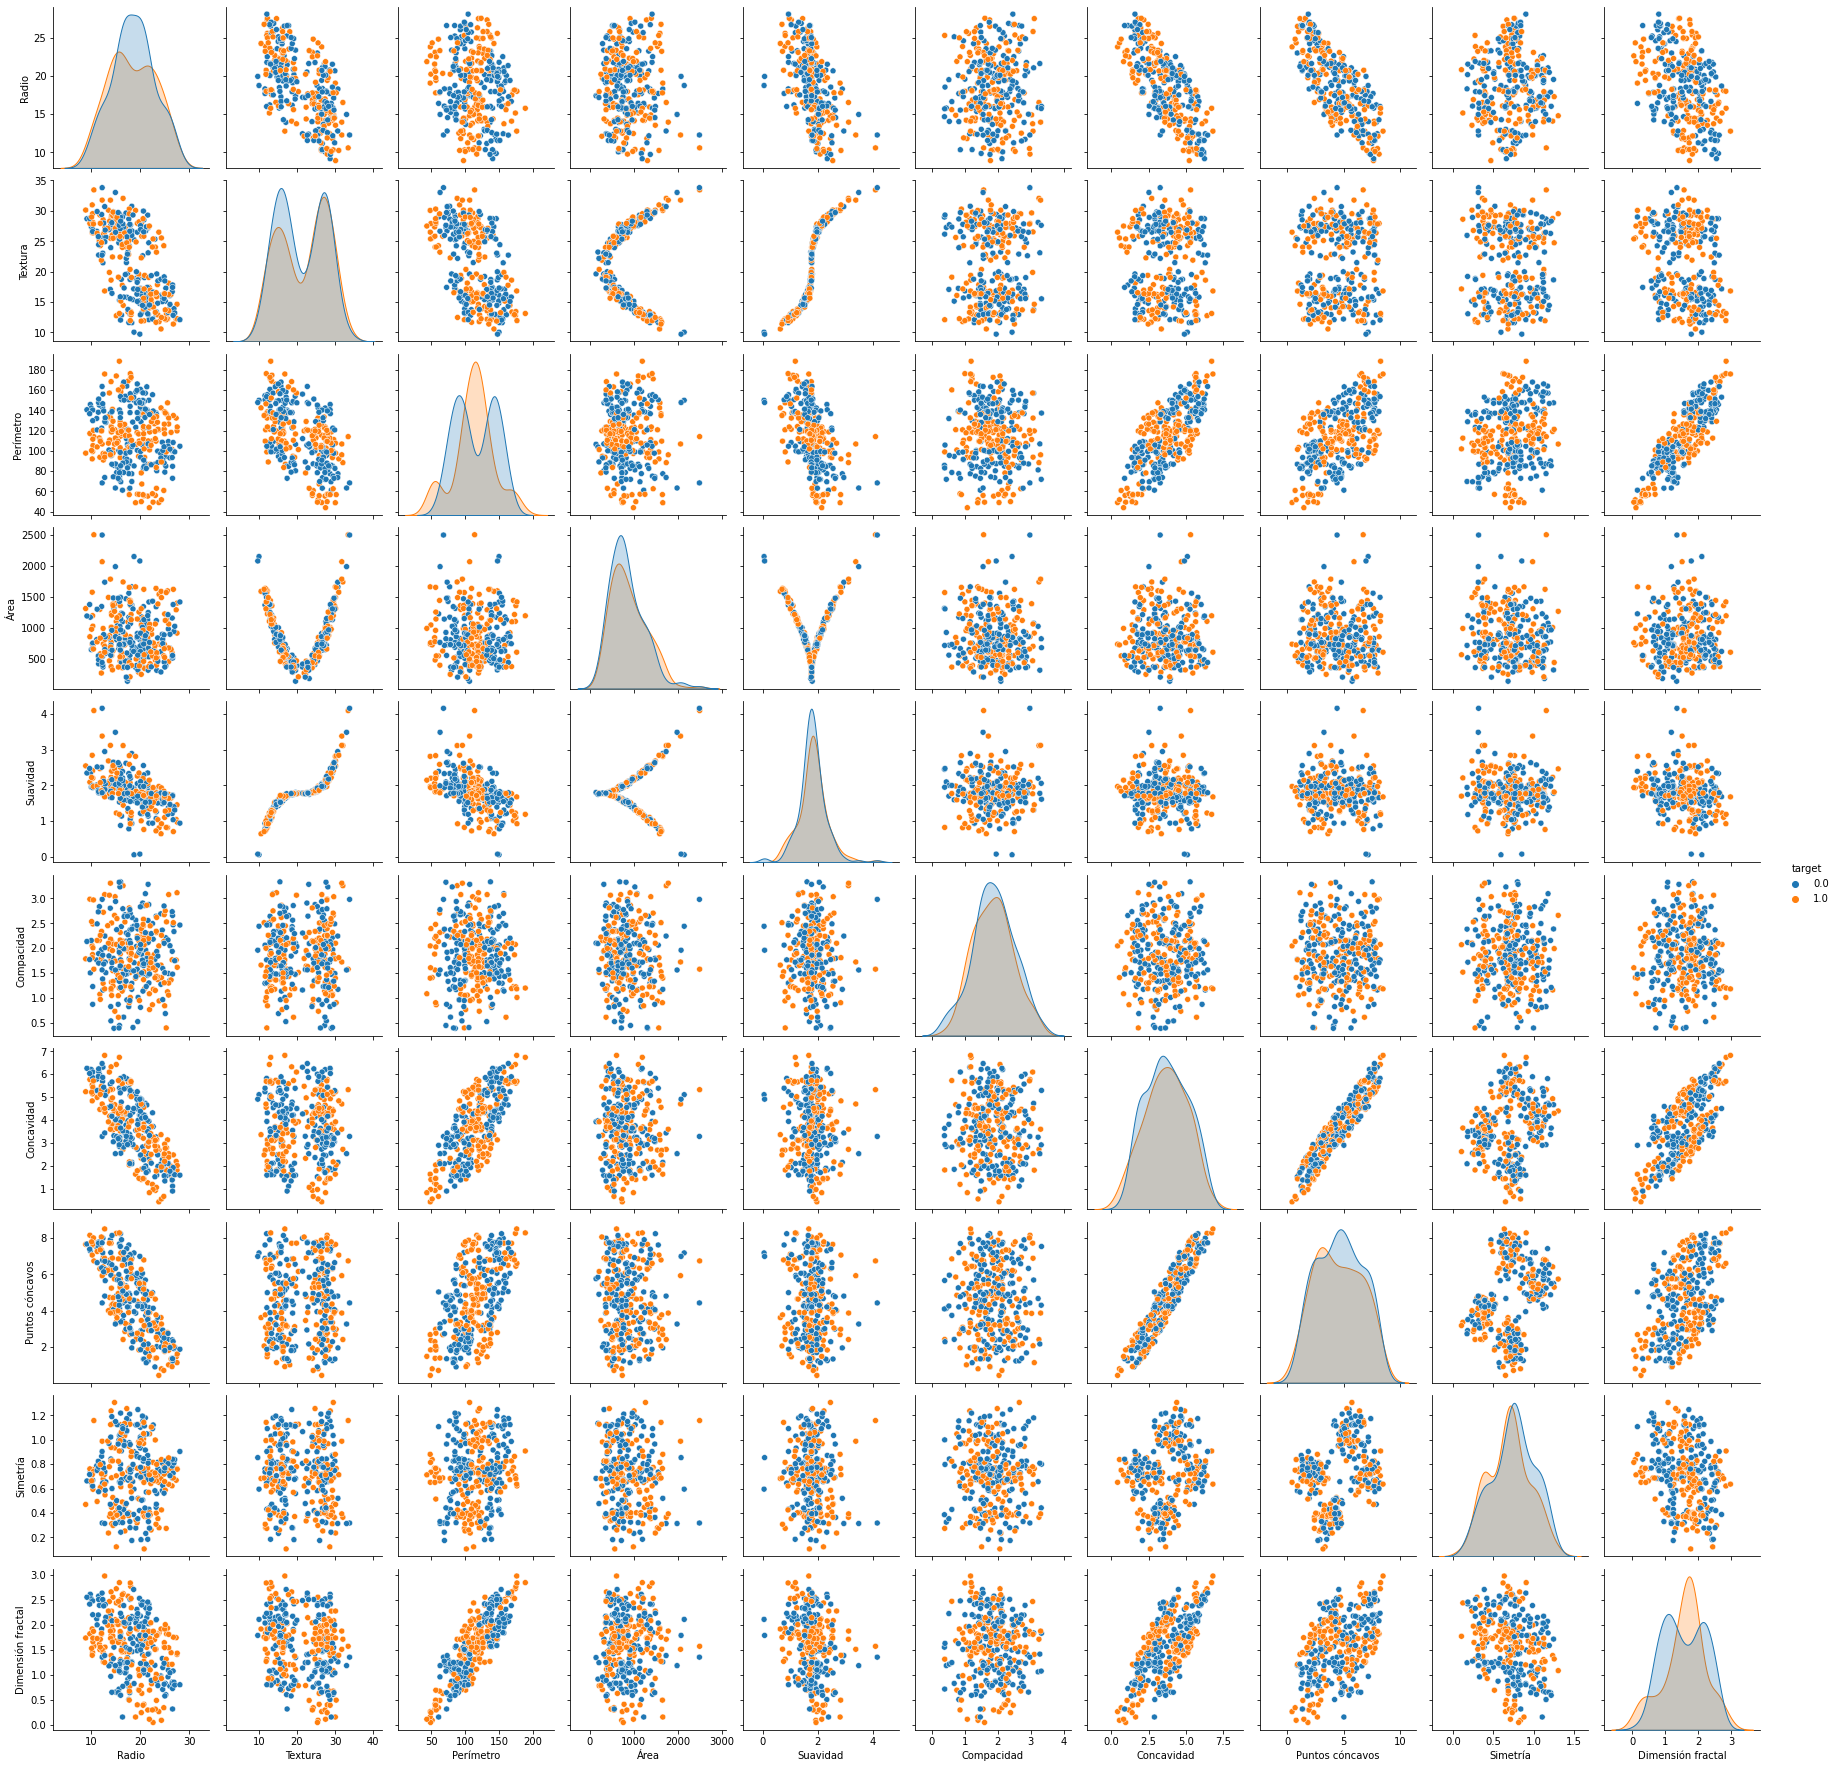

In [177]:
import seaborn as sns

sns.pairplot(df.assign(target=Z_train), hue="target")

Como se ve claramente en el gráfico, los datos de entrada presentan magnitudes diferentes entre sí, por lo que vamos a necesitar estandarizarlos, para lo cual le restamos a cada instancia su media y dividimos por su desvío estándar. Esto lo hacemos para tanto el conjunto de entrenamiento como el de test y el de validación, pero a éstos últimos se les resta la media y se divide por la varianza de los datos de entrenamiento, para no TODO.

In [179]:
X_train = (X_train - X_train.mean(axis=0)) / X_train.std(axis=0)
X_test = (X_test - X_train.mean(axis=0)) / X_train.std(axis=0)
X_val = (X_val - X_train.mean(axis=0)) / X_train.std(axis=0)

Ahora las escalas de los datos ya no son tan distintas entre sí, como se puede ver en el siguiente gráfico:

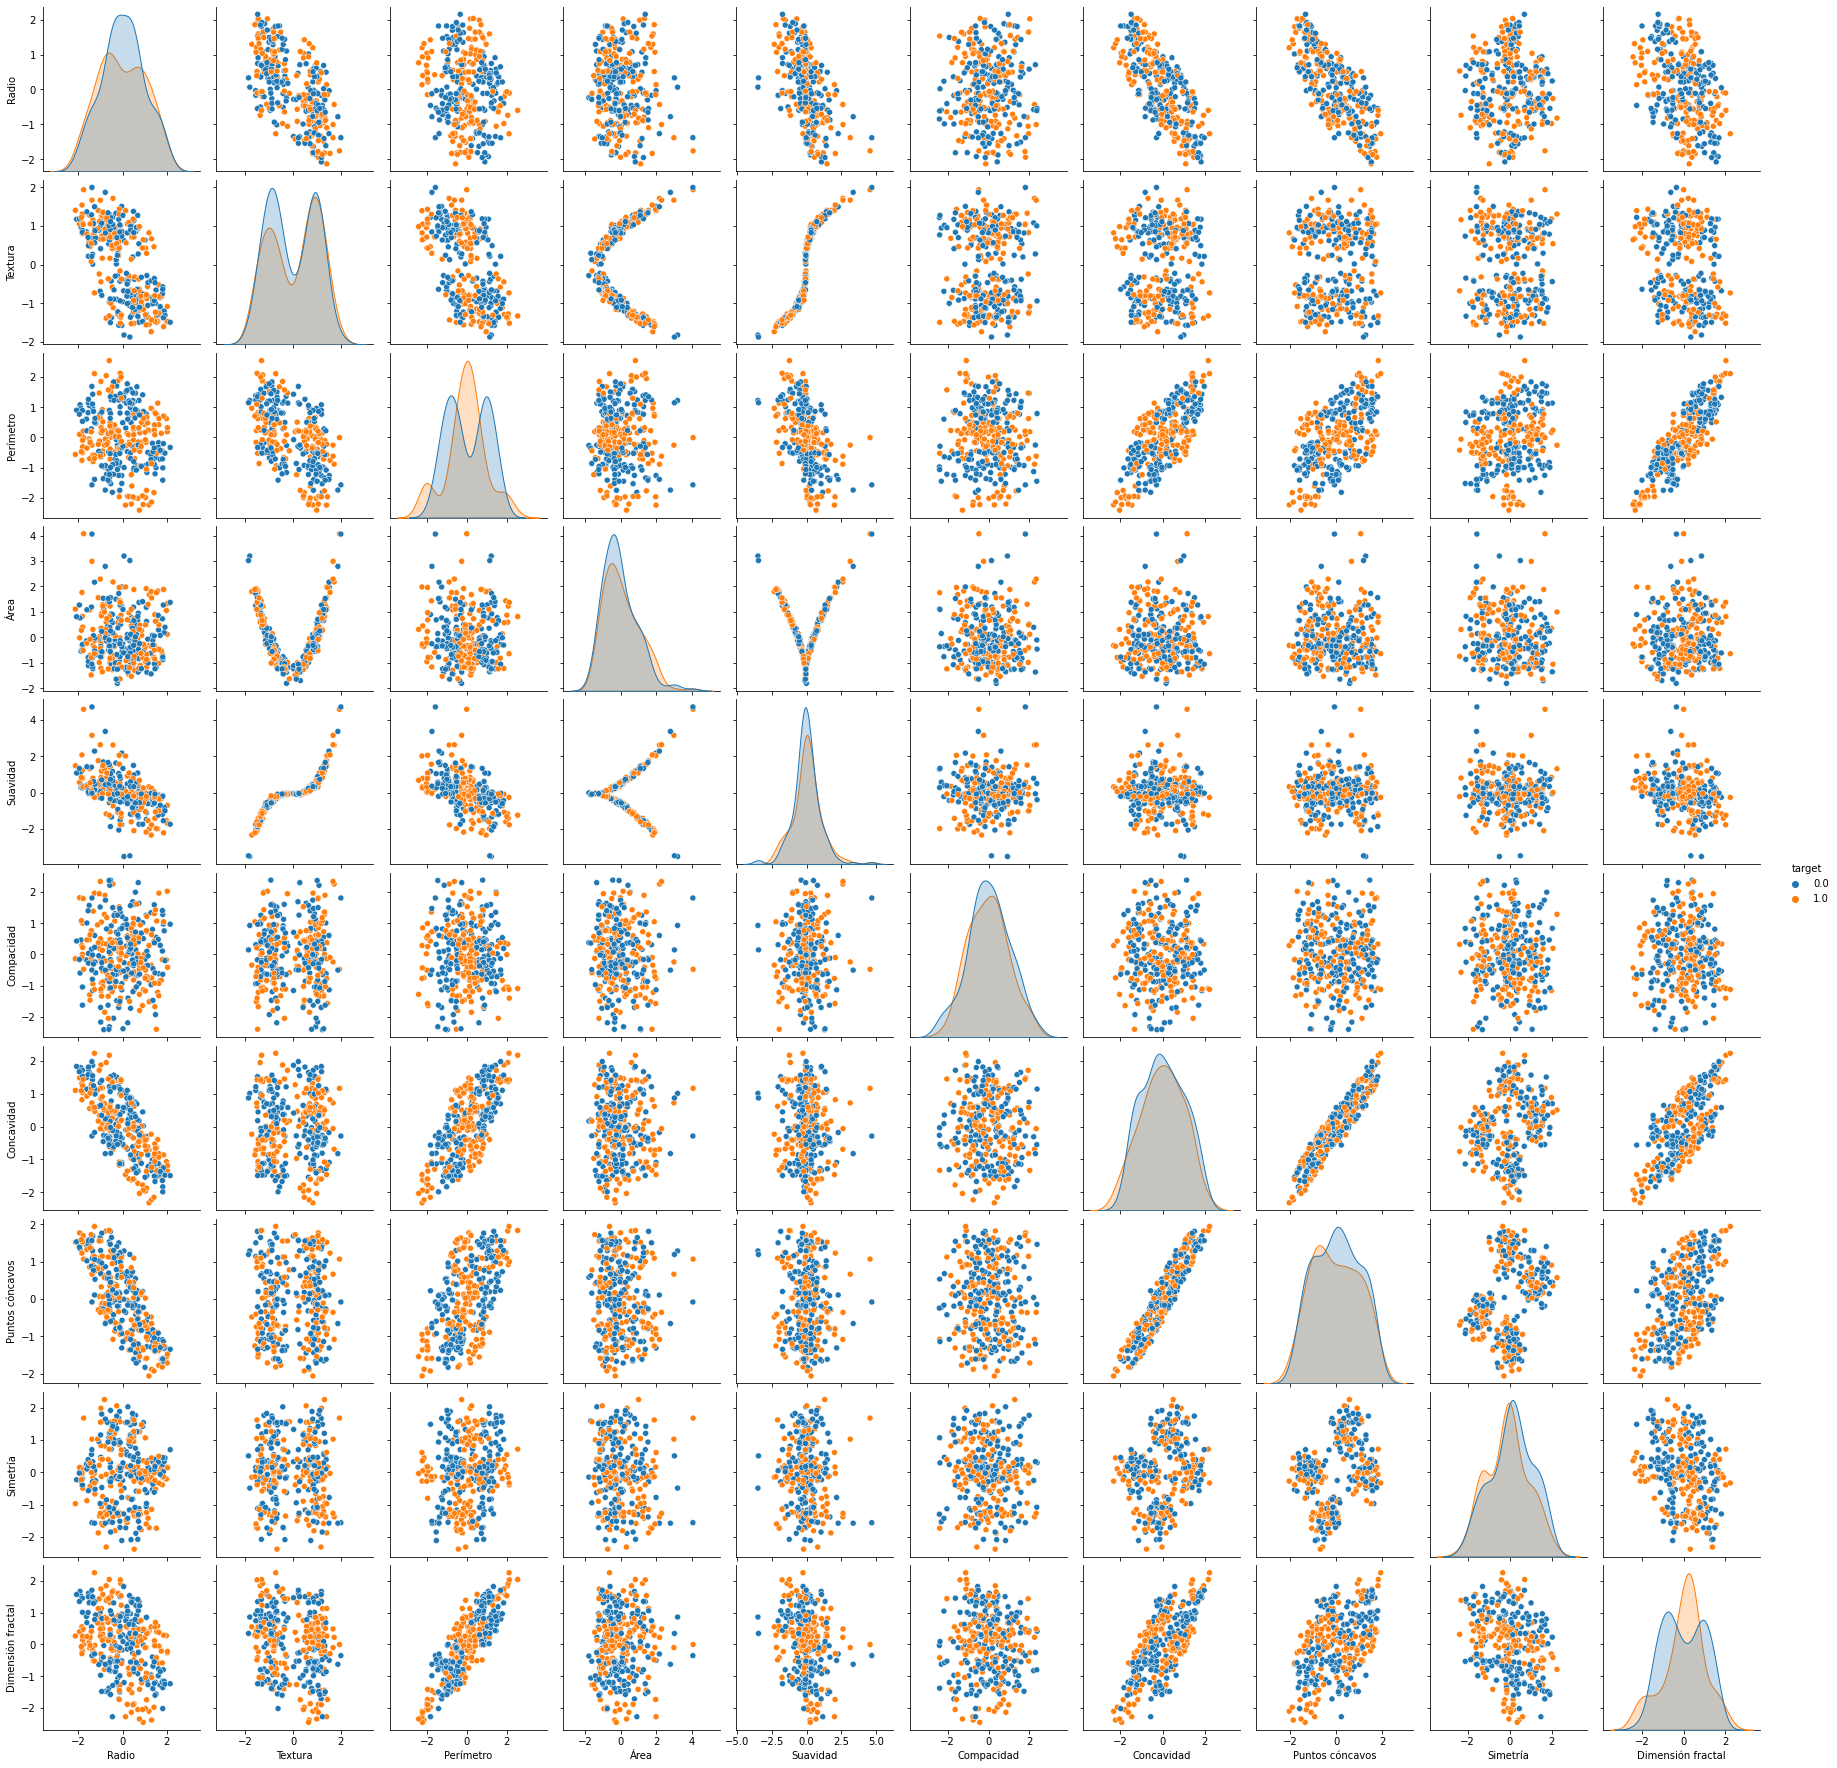

In [26]:
import seaborn as sns
df = pd.DataFrame(X_train, columns=['Radio', 'Textura', 'Perímetro', 'Área', 'Suavidad', 'Compacidad', 'Concavidad', 'Puntos cóncavos', 'Simetría', 'Dimensión fractal'])
sns.pairplot(df.assign(target=Z_train), hue="target")

A continuación, definimos la clase del modelo a utilizar, en el cual vamos a variar la cantidad de capas de la red y la distribución de nodos por capa para obtener intentar obtener una red neuronal que prediga el diagnóstico final.

In [180]:
P = X_train.shape[0]    # cantidad de instancias
N = 10                  # unidades de entrada
M = 1                   # unidades de salida
S = [N, 20, 8, M]       # distribución de nodos por capa

In [181]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [185]:
class MLPCancerDeMamas:
    def __init__(self, units_per_layers):
        self.batch_size = 8
        self.S = units_per_layers
        self.L = len(self.S)
        self.Y = self._initialize_Y() 
        self.W = self._initialize_W()  
        self.dW = self._initialize_dW() 
        self.lr = 1e-2

    def activation(self, X):
        activation = X

        for k in range(1, self.L):
            self.Y[k-1][:,:] = self._bias_add(activation)
            activation = np.tanh(self.Y[k-1] @ self.W[k])
        
        self.Y[self.L - 1] = activation

        return self.Y
    
    def correction(self, Z):
        E = Z.reshape((self.batch_size, 1)) - self.Y[self.L - 1]
        dY = 1 - np.square(self.Y[self.L - 1])

        D = [ np.empty_like(y) for y in self.Y]
        D[self.L-1] = E*dY

        for k in range(self.L-1, 0, -1):
            self.dW[k] = self.lr * (self.Y[k-1].T @ D[k])
            E = D[k] @ self.W[k].T
            dY = 1 - np.square(self.Y[k-1])
            D[k-1] = self._bias_sub(E*dY)
        return self.dW
    
    def adaptation(self):
        for k in range(1, self.L):
            self.W[k] += self.dW[k]
        return self.W
    
    def estimation(self, Z):
        return np.mean(np.square(Z.reshape((self.batch_size, 1)) - self.Y[self.L - 1]))


    def train(self, X, Z, epochs):
        t = 0
        errores = []
        while t < epochs:
            e = 0
            indices = np.random.permutation(len(X))
            for h in range(0, len(indices), self.batch_size):
                batch = indices[h:h + self.batch_size]
                Xh = X[batch]
                Zh = Z[batch]
                self.Y = self.activation(Xh)
                e += self.estimation(Zh)
                self.dW = self.correction(Zh)
                self.W = self.adaptation()

            errores.append(e)
            t += 1
            if t % 100 == 0:
                print(t, e)
        plt.plot(errores, 'r')
        plt.show()

        return self.W


    ## Funciones privadas

    def _bias_add(self, V):
        bias = np.ones((len(V), 1))
        return np.hstack([V, bias])


    def _bias_sub(self, V):
        return V[:,:-1]
    
    def _initialize_Y(self):
        Y = [ np.empty((self.batch_size, S[i]+1)) for i in range(self.L)]
        Y[self.L-1] = np.empty((self.batch_size, S[self.L - 1]))
        # Y = []
        # for i in range(self.L - 1):
        #     Y.append(np.zeros(self.S[i] + 1))
        
        # Y.append(np.zeros(self.S[self.L - 1 ]))
        return Y

    def _initialize_W(self):
        W = []
        W.append(np.array([]))
        W.extend(np.random.RandomState(seed=42).normal(0, 0.5, (self.S[i-1] + 1, self.S[i])) for i in range(1,self.L)) 
        return W

    def _initialize_dW(self): 
        dW = [np.empty_like(w) for w in self.W ]
        return dW

100 1.4167555419539748
200 0.5281508860297875
300 0.2907176831447604
400 0.1952597159222577
500 0.13895527714062078
600 0.1086744942916347
700 0.08664709805146437
800 0.07344752308637058
900 0.06228644173404835
1000 0.05308854825353344
1100 0.047150525098401654
1200 0.04191415646901747
1300 0.03725592835421647
1400 0.03378325202196939
1500 0.030396889302074178
1600 0.027778020987605824
1700 0.02587853442093233
1800 0.023306138214846533
1900 0.021759814094760178
2000 0.020526779728587217


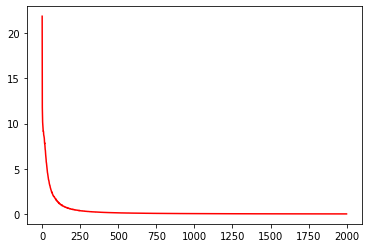

[array([], dtype=float64),
 array([[ 5.60373655e-01,  6.38647436e-02,  7.14673834e-01,
          1.00549070e+00, -1.57626482e-01, -3.03374184e-01,
          1.30723721e+00,  7.90786951e-01,  2.87937345e-01,
          3.56161335e-01, -7.11259353e-01, -6.41678746e-01,
          3.35594471e-01, -1.15527575e+00, -5.94201265e-01,
          2.39171240e-02, -1.00442935e+00, -4.09925489e-02,
         -3.23585168e-01, -1.01783034e+00],
        [ 7.97643949e-01, -6.10102589e-01, -2.58150134e-01,
         -7.47066935e-01, -5.75725665e-01,  3.30426739e-02,
         -1.46114627e+00,  6.72043420e-01, -8.77224922e-01,
         -3.23734015e-01,  2.92101222e-01,  1.46895764e+00,
          3.57860849e-02, -3.79140653e-01,  2.00781564e-01,
         -7.50790936e-01,  5.63232668e-01, -1.12803113e+00,
         -6.96432818e-01,  7.76904928e-01],
        [ 3.52151928e-01,  2.90320728e-01, -1.81326440e-04,
          8.70717476e-02, -1.09345079e+00,  1.34087809e-01,
          7.66110907e-02,  4.43907967e-01,  5

In [187]:
modelo = MLPCancerDeMamas(S)
modelo.train(X_train, Z_train, 2000)

## Eficiencia de energía

Tenemos los datos de un análisis energético realizado en varios edificios, con 10 característica cada uno. A diferencia del caso anterior, donde el problema era de clasificación (decidir entre dos etiquetas, a cuál pertenece cada instancia), en este caso tenemos un problema de regresión: se quieren predecir dos valores: **Carga de calefacción** y **Carga de refrigeración**, los cuales representan la carga energética necesaria para la calefacción y refrigeración de un edificion.

El objetivo es el mismo, encontrar determinar si hay un modelo de redes neuronales que prediga la carga energética.

Cargamos los datos, y los separamos en X (datos de entrada) y Z (datos objetivo).

In [12]:
r = requests.get('https://git.exactas.uba.ar/redes-neuronales/clases/-/raw/master/practicas/datos/tp1_ej2_training.csv')
data = np.loadtxt(r.iter_lines(), delimiter=',')

data = np.random.RandomState(seed=42).permutation(data)

X = data[:,:-2]

Z = data[:,[-2,-1]] # preguntar



Dividimos los datos en train, validation y test, con las mismas proporciones que en la sección anterior.

In [13]:
X_train, Z_train, X_val, Z_val, X_test, Z_test = split(X, Z, 0.05, 0.8, 0.15)

In [14]:
df = pd.DataFrame(X_train, columns=['Compacidad Relativa', 'Área de la Superficie Total', 'Área de las Paredes', 'Área del techo', 'Altura Total', 'Orientación', 'Área de Reflejo Total', 'Distribución del Área de Reflejo'])
df

Compacidad Relativa  Área de la Superficie Total  Área de las Paredes  \
0                  0.86                        588.0                294.0   
1                  0.90                        563.5                318.5   
2                  0.62                        808.5                367.5   
3                  0.71                        710.5                269.5   
4                  0.76                        661.5                416.5   
5                  0.71                        710.5                269.5   
6                  0.69                        735.0                294.0   
7                  0.71                        710.5                269.5   
8                  0.90                        563.5                318.5   
9                  0.90                        563.5                318.5   
10                 0.62                        808.5                367.5   
11                 0.71                        710.5                269.5   
12                 0.79                        637.0                343.0   
13                 0.98                        514.5                294.0   
14                 0.76                        661.5                416.5   
15                 0.90                        563.5                318.5   
16                 0.76                        661.5                416.5   
17                 0.64                        784.0                343.0   
18                 0.69                        735.0                294.0   
19                 0.71                        710.5                269.5   
20                 0.79                        637.0                343.0   
21                 0.86                        588.0                294.0   
22                 0.98                        514.5                294.0   
23                 0.79                        637.0                343.0   
24                 0.74                        686.0                245.0   

    Área del techo  Altura Total  Orientación  Área de Reflejo Total  \
0           147.00           7.0          3.0                   0.10   
1           122.50           7.0          3.0                   0.25   
2           220.50           3.5          2.0                   0.25   
3           220.50           3.5          4.0                   0.10   
4           122.50           7.0          2.0                   0.25   
5           220.50           3.5          5.0                   0.00   
6           220.50           3.5          3.0                   0.40   
7           220.50           3.5          3.0                   0.40   
8           122.50           7.0          4.0                   0.10   
9           122.50           7.0          5.0                   0.25   
10          220.50           3.5          3.0                   0.40   
11          220.50           3.5          2.0                   0.40   
12          147.00           7.0          3.0                   0.40   
13          110.25           7.0          2.0                   0.25   
14          122.50           7.0          4.0                   0.10   
15          122.50           7.0          2.0                   0.10   
16          122.50           7.0          3.0                   0.25   
17          220.50           3.5          2.0                   0.25   
18          220.50           3.5          3.0                   0.40   
19          220.50           3.5          4.0                   0.10   
20          147.00           7.0          3.0                   0.25   
21          147.00           7.0          3.0                   0.40   
22          110.25           7.0          2.0                   0.10   
23          147.00           7.0          4.0                   0.25   
24          220.50           3.5          2.0                   0.25   

    Distribución del Área de Reflejo  
0                                3.0  
1                                2.0  
2          

In [15]:
P = len(X)
N = 10                  # unidades de entrada
M = 1                   # unidades de salida
S = [N, 20, 8, M]       # distribución de nodos por capa
LR = 1e-3               # learning rate

In [16]:
class MLPEficienciaDeEnergía:
    def __init__(self, units_per_layers):
        #self.batch_size = 16
        self.S = units_per_layers
        self.L = len(self.S)
        self.Y = self._initialize_Y() 
        self.W = self._initialize_W()  
        self.dW = self._initialize_dW() 
        self.lr = 1e-2

    def activation(self, X):
        activation = X

        for k in range(1, self.L):
            self.Y[k-1] = self._bias_add(activation)
            activation = np.tanh(self.Y[k-1] @ self.W[k])
        
        self.Y[self.L - 1] = activation

        return self.Y
    
    def correction(self, Z):
        E = Z - self.Y[self.L - 1]
        dY = 1 - np.square(self.Y[self.L - 1])

        D = [None] * (self.L)
        D[self.L-1] = E*dY
        for k in range(self.L-1, 0, -1):
            self.dW[k] = self.lr * (self.Y[k-1].T @ D[k])
            
            E = D[k] @ self.W[k].T
            dY = 1 - np.square(self.Y[k-1])
            D[k-1] = self._bias_sub(E*dY)
        return self.dW
    
    def adaptation(self):
        return [ self.W[k] + self.dW[k] for k in range(self.L-1) ]
    
    def estimation(self, Z):
        return np.sum(np.square(Z-self.Y))


    def train(self, X, Z, epochs):
        t = 0
        errores = []
        while t < epochs:
            # e = 0
            self.activation(X)
            self.correction(Z)
            self.adaptation()
            # indices = np.random.permutation(len(X))
            # for batch in range(0, len(indices), self.batch_size):
            #     h  = indices[batch : batch + self.batch_size]
            #     Xh = X[h]
            #     Zh = Z[h]
            #     Yh = self.activation(Xh)
            #     e += np.mean(np.square(np.subtract(Zh, np.sign(Yh[self.L-1].T))))
            #     dW = self.correction(Zh)
            #     W  = self.adaptation()
            #errores.append(e)
            t += 1
        #     if t % 100 == 0:
        #         print(t, e)
        # plt.plot(errores, 'r')
        # plt.show()
    
        return self.W

    ## Funciones privadas

    def _bias_add(self, V):
        bias = np.ones((len(V), 1))
        return np.hstack([V, bias])

    def _bias_sub(self, V):
        return V[:,:-1]
    
    def _initialize_Y(self):
        # Y = [ np.zeros((self.batch_size, self.S[i]+1)) for i in range(self.L)]
        Y = []
        for i in range(self.L - 1):
            Y.append(np.zeros(self.S[i] + 1))
        
        Y.append(np.zeros(self.S[self.L - 1 ]))
        return Y

    def _initialize_W(self):
        W = []
        W.append(np.array([]))
        W.extend(np.random.normal(0, 1, (self.S[i-1] + 1, self.S[i])) for i in range(1,self.L)) 
        return W

    def _initialize_dW(self): 
        dW = []
        dW.append(np.array([]))
        dW.extend(np.zeros((self.S[i-1] + 1, self.S[i])) for i in range(1,self.L)) 
        return dW